To celebrate fourteen years(!) of sporadically writing here and break a bit of a recent dry spell, I thought it would be fun to revisit this blog's [first post](https://austinrochford.com/posts/2013-04-25-probability-and-deuces-in-tennis.html) on probability theory and deuces and tennis.  Specifically, this post will investigate whether or not historical match data aligns with the theoretical results drived in that post.

That post summed an infinite series to show that if the probability a server wins a single point is $p$, the probability that they win a game from [deuce](https://en.wikipedia.org/wiki/Glossary_of_tennis_terms#Deuce) is

$$P(\text{Server wins from deuce}\ |\ p) = \frac{p^2}{1 - 2p \cdot (1 - p)}.$$ 

The plot below contrasts this function with the line $y = x$, to show how the deuce structure of tennis advantages better players more than one might expect.

In [1]:
%matplotlib inline

In [2]:
from fastprogress.fastprogress import progress_bar
from itertools import product
from urllib.parse import urljoin
from warnings import filterwarnings

In [3]:
from matplotlib import ticker, pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
filterwarnings("ignore", category=pd.errors.DtypeWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [5]:
sns.set(color_codes=True)

pct_formatter = ticker.StrMethodFormatter("{x:.1%}")

In [6]:
def theory_win_prob(p):
    return p**2 / (1 - 2 * p * (1 - p))

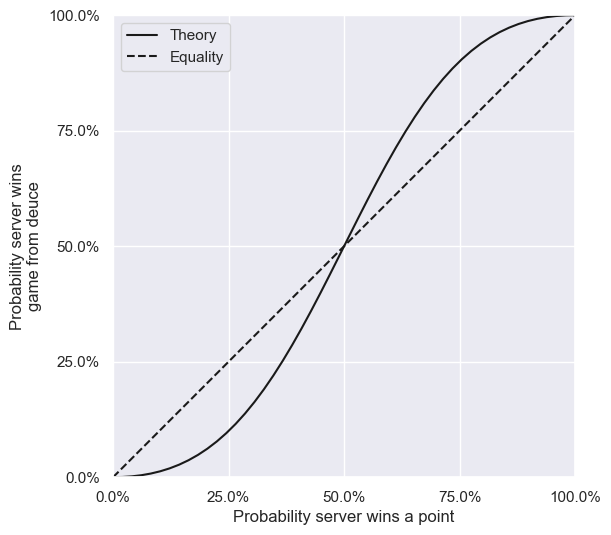

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal");

p_grid = np.linspace(0, 1, 50)

ax.plot(p_grid, theory_win_prob(p_grid), c="k", label="Theory");
ax.axline((0, 0), slope=1, c="k", ls="--", label="Equality");

ax.set_xlim(0, 1);
ax.xaxis.set_major_formatter(pct_formatter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25));
ax.set_xlabel("Probability server wins a point");

ax.set_ylim(0, 1);
ax.yaxis.set_major_formatter(pct_formatter);
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25));
ax.set_ylabel("Probability server wins\ngame from deuce");

ax.legend();

As a former calculus teacher, this derivation warms hy heart; as a statistician, it piques my curiosity.

## Load the data

To see how well this theory holds up in reality, we load point-by-point data from singles matches in most major tournaments since 2011.  Many thanks to [Jeff Slackmann](https://github.com/JeffSackmann) of [Tennis Abstract](https://www.tennisabstract.com/) for making this data available under a [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license on [GitHub](https://github.com/JeffSackmann/tennis_slam_pointbypoint).

In [8]:
YEARS = range(2011, 2024)
TOURNAMENTS = ["ausopen", "frenchopen", "usopen", "wimbledon"]

In [9]:
DATA_PATH_BASE = "https://raw.githubusercontent.com/JeffSackmann/tennis_slam_pointbypoint/master/"

def get_data_path(year, tournament):
    return urljoin(DATA_PATH_BASE, f"{year}-{tournament}-points.csv")

In [10]:
EXCLUDE = {
    # wimbledon was cancelled in 2020 due to covid
    # see https://en.wikipedia.org/wiki/2020_Wimbledon_Championships
    (2020, "wimbledon"),

    # there is no australian or french open data for 2022 and 2023
    (2022, "ausopen"),
    (2022, "frenchopen"),
    (2023, "ausopen"),
    (2023, "frenchopen")
}

In [11]:
data_paths = [
    get_data_path(year, tournament) for year, tournament in product(YEARS, TOURNAMENTS)
        if (year, tournament) not in EXCLUDE
]

In [12]:
DTYPES = {
    "match_id": str,
    "SetNo": int,
    "GameNo": int,
    "P1Score": str,
    "P2Score": str,
    "PointServer": int,
    "PointWinner": int,
    "GameWinner": int
}

INDEX = [
    "match_id",
    "set_no",
    "game_no"
]

In [13]:
def to_snake_case(camel_case):
    chars = []
    
    if camel_case:
        fst, *rest = camel_case
        chars.append(fst.lower())

        for char in rest:
            if char.isupper():
                chars.append("_")

            chars.append(char.lower())

    return "".join(chars)

In [14]:
point_dfs = [pd.read_csv(path, usecols=DTYPES.keys()) for path in progress_bar(data_paths)]

point_df = (
    pd.concat(point_dfs, ignore_index=True)
      .dropna()
      .astype(DTYPES)
      .rename(columns=to_snake_case)
      .set_index(INDEX)
      .query("point_winner != 0")
)

In [15]:
point_df

game_winner  point_winner  point_server  \
match_id            set_no game_no                                            
2011-ausopen-1101   1      1                  0             1             2   
                           1                  0             1             2   
                           1                  0             1             2   
                           1                  1             1             2   
                           2                  0             1             1   
...                                         ...           ...           ...   
2023-wimbledon-2701 2      10                 0             1             1   
                           10                 0             1             1   
                           10                 0             1             1   
                           10                 0             2             1   
                           10                 1             1             1   

                                   p1_score p2_score  
match_id            set_no game_no                    
2011-ausopen-1101   1      1             15        0  
                           1             30        0  
                           1             40        0  
                           1              0        0  
                           2             15        0  
...                                     ...      ...  
2023-wimbledon-2701 2      10            15        0  
                           10            30        0  
                           10            40        0  
                           10            40       15  
                           10             0        0  

[1449025 rows x 5 columns]

There is information on more than 1.4 million points, which should give us plenty of data to compare to our theoretical calculations.

The original data set contains many more columns than we have loaded here, which are only those relevant for the task at hand.  These columns are:

* **`match_id`** - a unique identifier for the match
* **`set_no`** - the number of the set within the match
* **`game_no`** - the number of the game within the match
* **`game_winner`** - if this point decided the current game, which player won the game, otherwise zero
* **`point_winner`** - the player that won the point
* **`p1_score`** - player one's score at the beginning of the point
* **`p2_score`** - player two's score at the beginning of the point

## Analysis

### Probability server wins the point

First, we use this data to calculate the probability a player wins a point that they serve.

In [16]:
point_df["server_won_point"] = point_df["point_server"] == point_df["point_winner"]

In [17]:
point_df["server_won_point"].value_counts(normalize=True)

server_won_point
True     0.614043
False    0.385957
Name: proportion, dtype: float64

As expected, we see that serving is a significant advantage, with players winning more than 60% of points that they serve.

A quick pivot table gives the probability that each player wins a point that they serve for each match in the data.

In [18]:
server_point_prob = point_df.pivot_table(
    index="match_id",
    values="server_won_point",
    columns="point_server"
)

In [19]:
server_point_prob

point_server,1,2
match_id,,
2011-ausopen-1101,0.714286,0.076923
2011-ausopen-1103,0.717391,0.597826
2011-ausopen-1105,0.716981,0.652174
2011-ausopen-1108,0.520000,0.746269
2011-ausopen-1112,0.553571,0.651376
...,...,...
2023-wimbledon-2503,0.653465,0.580247
2023-wimbledon-2504,0.514706,0.650794
2023-wimbledon-2601,0.450000,0.596774


Note that since we have grouped by `match_id`, these probabilities are implicitly conditioned on both the server and their opponent, which is appropriate, as it implicitly accounts for the skill difference between the two players in question.

### Identifying games that reach deuce

With these probabilities in hand, we turn to identifying games with deuces and their winners.  Recall that a deuce is reached when the score in a game is 40-40.  We first identify deuce points and reduce to games that reach deuce.

In [20]:
point_df["is_deuce"] = (point_df["p1_score"] == "40") & (point_df["p2_score"] == "40")

In [21]:
deuce_df = (
    point_df.groupby(INDEX)
            [["game_winner", "point_server", "is_deuce"]]
            .max()
            .rename(columns={
                "game_winner": "winner",
                "point_server": "server",
                "is_deuce": "has_deuce"
            })
            .query("has_deuce")
)

In [22]:
deuce_df

winner  server  has_deuce
match_id            set_no game_no                           
2011-ausopen-1101   2      2             1       1       True
2011-ausopen-1103   1      8             2       2       True
                    2      3             1       2       True
                    3      9             2       2       True
                           10            1       1       True
...                                    ...     ...        ...
2023-wimbledon-2602 3      6             1       2       True
                           8             2       2       True
2023-wimbledon-2701 1      3             1       2       True
                           4             1       1       True
                    2      2             2       1       True

[55107 rows x 3 columns]

We see that more than 55,000 games reach deuce, providing plenty of data to compare to the theoritcal results.

### Comparing theory and reality

The final step to (in)validating the theoretical result is to join the deuce data to the server point probabilities to produce the probability that the server of each deuce wins a point.

In [23]:
aligned_server_point_prob, _ = server_point_prob.align(deuce_df, axis=0)

deuce_df["server_point_prob"] = aligned_server_point_prob[1].where(
    deuce_df["server"] == 1,
    aligned_server_point_prob[2]
)

In [24]:
deuce_df["server_won"] = deuce_df["server"] == deuce_df["winner"]

In [25]:
deuce_df

winner  server  has_deuce  \
match_id            set_no game_no                              
2011-ausopen-1101   2      2             1       1       True   
2011-ausopen-1103   1      8             2       2       True   
                    2      3             1       2       True   
                    3      9             2       2       True   
                           10            1       1       True   
...                                    ...     ...        ...   
2023-wimbledon-2602 3      6             1       2       True   
                           8             2       2       True   
2023-wimbledon-2701 1      3             1       2       True   
                           4             1       1       True   
                    2      2             2       1       True   

                                    server_point_prob  server_won  
match_id            set_no game_no                                 
2011-ausopen-1101   2      2                 0.714286        True  
2011-ausopen-1103   1      8                 0.597826        True  
                    2      3                 0.597826       False  
                    3      9                 0.597826        True  
                           10                0.717391        True  
...                                               ...         ...  
2023-wimbledon-2602 3      6                 0.633333       False  
                           8                 0.633333        True  
2023-wimbledon-2701 1      3                 0.466667       False  
                           4                 0.553846        True  
                    2      2                 0.553846       False  

[55107 rows x 5 columns]

To compare this data to the theoretical result, we group the deuces into fifty bins based on the probability that the server wins a point, each with an equal number of samples, and calculate the empirical rate at which the server won the deuce game within each bin.

In [26]:
N_BIN = 50

In [27]:
deuce_df["binned_server_point_prob"] = (
    pd.qcut(deuce_df["server_point_prob"], N_BIN)
      .apply(lambda interval: interval.mid)
)

In [28]:
test_df = (
    deuce_df.groupby("binned_server_point_prob")
            ["server_won"]
            .mean()
            .reset_index()
)

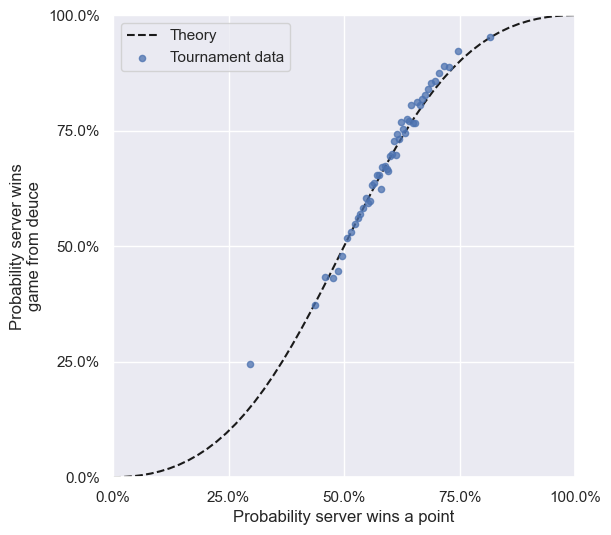

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal");

ax.plot(p_grid, theory_win_prob(p_grid),
        c="k", ls="--", label="Theory");

test_df.plot(
    kind="scatter", x="binned_server_point_prob", y="server_won",
    zorder=5, alpha=0.75, label="Tournament data",
    ax=ax
);

ax.set_xlim(0, 1);
ax.xaxis.set_major_formatter(pct_formatter);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25));
ax.set_xlabel("Probability server wins a point");

ax.set_ylim(0, 1);
ax.yaxis.set_major_formatter(pct_formatter);
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25));
ax.set_ylabel("Probability server wins\ngame from deuce");

ax.legend();

Except for the very first bin, we see quite remarkable agreement between the empirical tournament data and the theoretical result from the prior post.  I always enjoy when simple mathematical models map so cleanly to reality!

Note that this analysis could be made more rigorous by only using points that occur in the match prior to the deuce in question to calculate the probability that the server wins a point they serve.  For the purposes of this post, I am satisfied using all points in a match to calculate this probability, even though it is leaking some information from the future into the analysis of each deuce.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/8998cd31f43d8adcf5bd743aaa6c10f1).

In [30]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Tue Jul 30 2024

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.11.0

pandas    : 2.0.3
matplotlib: 3.7.1
numpy     : 1.24.2
seaborn   : 0.12.2

